### Example taken from *A Low-Complexity Quantum Principal Component Analysis Algorithm*
https://doi.org/10.1109/TQE.2021.3140152

In [519]:
import numpy as np
import itertools
from qiskit_experiments.library import StateTomography
from qiskit.visualization import plot_state_city
import qiskit.quantum_info as qi
from qiskit.visualization import plot_histogram

example_matrix = np.array([[7, 4], [4, 7]])
#example_matrix=np.array([[3,2],[3,2]])
#example_matrix=np.dot(example_matrix,example_matrix.T)
# example_matrix = np.dot(np.array([[1.3, 0.35], [0.4, 1.1]]),np.array([[1.3, 0.35], [0.4, 1.1]]).T)
big_example_matrix = np.array([[0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 2, 0], [0, 0, 0, 3]])

sum_squares = (example_matrix**2).sum()
input_probabilities = (example_matrix**2/sum_squares).flatten()

print(input_probabilities)

[0.37692308 0.12307692 0.12307692 0.37692308]


In [520]:
example_matrix

array([[7, 4],
       [4, 7]])

In [521]:
np.linalg.eig(example_matrix)

(array([11.,  3.]),
 array([[ 0.70710678, -0.70710678],
        [ 0.70710678,  0.70710678]]))

as an example, whose quantum state is given by
$$\left|\psi_{A_0}\right\rangle=\frac{3}{\sqrt{20}}|00\rangle+\frac{1}{\sqrt{20}}|01\rangle+\frac{1}{\sqrt{20}}|10\rangle+\frac{3}{\sqrt{20}}|11\rangle .$$

Note that the eigenvalues and the corresponding eigenvectors obtained by classical PCA are given by
$$\lambda_1=2, u_1=[1,1]^T$$
$$\lambda_2=1, u_2=[−1,1]^T.$$

Note: $[1, 0]^T = |0〉$ and $[0, 1]^T = |1〉.$ 

When we take a threshold τ=1.1 for eigenvalues, the eigenvalue in binary $|λ_1〉=|10〉$ and the corresponding eigenvector $|u_1〉=[1,1]^T=\frac{1}{\sqrt{2}}|0〉+\frac{1}{\sqrt{2}}|1〉$ are considered as principal components. Therefore, the output of the proposed algorithm should be given by

$$\begin{aligned}
\left|\psi_A^{\prime}\right\rangle &=\left|\lambda_1\right\rangle\left|u_1\right\rangle\left|u_1\right\rangle \\
&=|10\rangle \otimes\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \otimes\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \\
&=\frac{1}{2}|1000\rangle+\frac{1}{2}|1001\rangle+\frac{1}{2}|1010\rangle+\frac{1}{2}|1011\rangle .
\end{aligned}$$

In [522]:
#Tommaso's great code for computing the thetas

lst_combination=[]

for k in range(1, len(example_matrix)+1):
    lst_combination.append(list(map(list, itertools.product([0, 1], repeat=k))))
container=[]
for lst in lst_combination:
    container.append([''.join([''.join(str(j)) for j in i]) for i in lst])
all_combinations=[item for c in container for item in c]

general_bitstring=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=len(example_matrix))))]

#Nodes contains all the values of the tree (except for the root)
nodes=[]
for st in all_combinations:
    #print(st)
    starts = [general_bitstring.index(l) for l in general_bitstring if l.startswith(st)]
    #print(starts)
    print(st,'->',np.sqrt(input_probabilities[starts].sum()))
    nodes.append(np.sqrt(input_probabilities[starts].sum()))

#add root tree
nodes.insert(0, 1)

idx_sub=1
thetas=[]
for i in range(len(nodes)-len(input_probabilities)):
    right_node=i+idx_sub
    left_node=right_node+1
    #print(left_node,right_node)
    if nodes[i]!=0:
        #print(nodes[right_node],nodes[i])
        thetas.append(2*np.arccos(nodes[right_node]/nodes[i]))
        thetas.append(2*np.arcsin(nodes[left_node]/nodes[i]))
    else:
        thetas.append(0)
        thetas.append(0)
        
    idx_sub+=1

# SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# for idx,th in zip(all_combinations,thetas):
#     print('\u03F4(R{})'.format((str(idx).translate(SUB))),'->', th)
thetas

0 -> 0.7071067811865476
1 -> 0.7071067811865476
00 -> 0.6139406135149205
01 -> 0.35082320772281167
10 -> 0.35082320772281167
11 -> 0.6139406135149205


[1.5707963267948966,
 1.5707963267948968,
 1.038292228493046,
 1.0382922284930458,
 2.1033004250967475,
 2.103300425096747]

In [523]:
from qiskit.circuit.library.standard_gates import RYGate

def generate_qram_circuit(thetas, all_combinations):
    
    right_nodes_indexes=list(range(0,len(thetas),2))
    rotations_list=list(zip(np.array(all_combinations)[right_nodes_indexes],np.array(thetas)[right_nodes_indexes]))

    qc=QuantumCircuit(len(example_matrix))

    for r_l in rotations_list:
        target_qubit=len(r_l[0])-1
        
        #First case of R_0
        if target_qubit==0:
            qc.ry(theta=r_l[1],qubit=target_qubit)
            continue
            
        not_gate=[]
        for qb in range(target_qubit):
            if r_l[0][qb]=='0':
                not_gate.append(qb)
                
        c_t_qubits=list(range(len(r_l[0])))
        n_controls=len(range(target_qubit))
        
        if len(not_gate)>0:
            qc.x(not_gate)
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
            qc.x(not_gate)
        else:
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
    return qc

In [524]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

matrix_circuit = generate_qram_circuit(thetas, all_combinations)

matrix_circuit.draw()


┌─────────┐┌───┐              ┌───┐              
q_0: ┤ Ry(π/2) ├┤ X ├──────■───────┤ X ├──────■───────
     └─────────┘└───┘┌─────┴──────┐└───┘┌─────┴──────┐
q_1: ────────────────┤ Ry(1.0383) ├─────┤ Ry(2.1033) ├
                     └────────────┘     └────────────┘

In [525]:
from qiskit import Aer, transpile, execute
from qiskit.visualization import plot_histogram

backend = Aer.get_backend("statevector_simulator")
job = backend.run(transpile(matrix_circuit, backend=backend))
job.result().get_counts()


{'00': 0.376923076923077,
 '01': 0.123076923076923,
 '10': 0.123076923076923,
 '11': 0.376923076923077}

In [526]:
# from scipy.linalg import expm
# from qiskit.quantum_info.operators import Operator

# U  = expm(big_matrix*(2*np.pi*1j/4))
# np.set_printoptions(suppress=True)
# operator_U = Operator(U)
# operator_U

In [527]:
from qiskit.algorithms.linear_solvers.matrices.numpy_matrix import NumPyMatrix

unitary_backend = Aer.get_backend("unitary_simulator")
u_circuit = NumPyMatrix(example_matrix, evolution_time=2*np.pi/4)
unitary_job = unitary_backend.run(transpile(u_circuit, backend=unitary_backend))
unitary_job.result().get_unitary()

/var/folders/rr/g930v2cj1wvdzc257kclm3lm0000gn/T/ipykernel_4338/963539654.py:4: DeprecationWarning: The NumPyMatrix class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  u_circuit = NumPyMatrix(example_matrix, evolution_time=2*np.pi/4)


Operator([[-1.8369702e-16-1.j,  0.0000000e+00-0.j],
          [ 0.0000000e+00-0.j, -1.8369702e-16-1.j]],
         input_dims=(2,), output_dims=(2,))

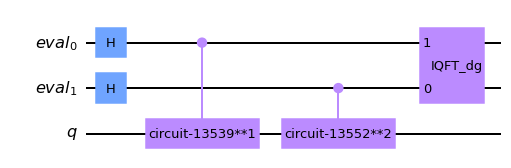

In [528]:
from qiskit.circuit.library import PhaseEstimation

resolution = 2
pe = PhaseEstimation(resolution, u_circuit, name = "PE")
pe.decompose().draw("mpl")

# Check Statevector

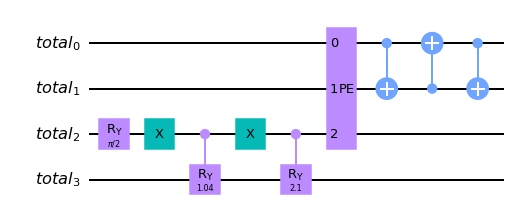

In [529]:
tot_qubit = resolution+len(example_matrix)

qr_total = QuantumRegister(tot_qubit, 'total')
# classical = ClassicalRegister(4, 'measure')

total_circuit = QuantumCircuit(qr_total , name='matrix')

total_circuit.append(matrix_circuit.to_gate(), qr_total[resolution:])
total_circuit.append(pe.to_gate(), qr_total[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
total_circuit.swap(qr_total[0],qr_total[1])
#total_circuit.measure_all()

total_circuit.decompose(reps=1).draw("mpl")

In [530]:
from qiskit.visualization import plot_histogram

backend_total = Aer.get_backend("statevector_simulator")
job = backend_total.run(transpile(total_circuit, backend=backend_total))
statevector = np.asarray(job.result().get_statevector()).round(4)
#plot_histogram(counts)

In [531]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=4)))]
bitstrings

['0000',
 '0001',
 '0010',
 '0011',
 '0100',
 '0101',
 '0110',
 '0111',
 '1000',
 '1001',
 '1010',
 '1011',
 '1100',
 '1101',
 '1110',
 '1111']

In [532]:
def attach_bitstrings(vector):
    return list(zip(bitstrings, vector))

In [533]:
attach_bitstrings(statevector)

[('0000', -0j),
 ('0001', 0j),
 ('0010', 0j),
 ('0011', (0.6139-0j)),
 ('0100', -0j),
 ('0101', 0j),
 ('0110', 0j),
 ('0111', (0.3508-0j)),
 ('1000', 0j),
 ('1001', 0j),
 ('1010', (-0+0j)),
 ('1011', (0.3508-0j)),
 ('1100', (-0-0j)),
 ('1101', 0j),
 ('1110', 0j),
 ('1111', (0.6139+0j))]

# Computing Probabilities

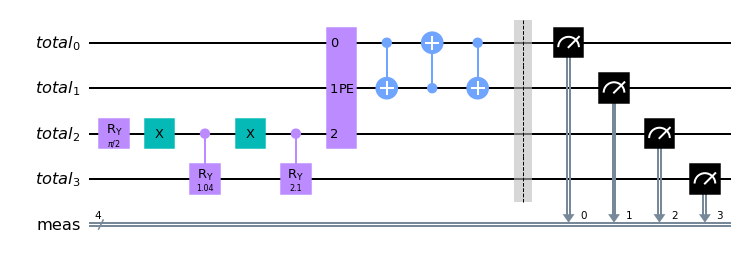

In [534]:
tot_qubit = resolution+len(example_matrix)

qr_total = QuantumRegister(tot_qubit, 'total')
# classical = ClassicalRegister(4, 'measure')

total_circuit_1 = QuantumCircuit(qr_total , name='matrix')

total_circuit_1.append(matrix_circuit.to_gate(), qr_total[resolution:])
total_circuit_1.append(pe.to_gate(), qr_total[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
total_circuit_1.swap(qr_total[0],qr_total[1])
total_circuit_1.measure_all()

total_circuit_1.decompose(reps=1).draw("mpl")

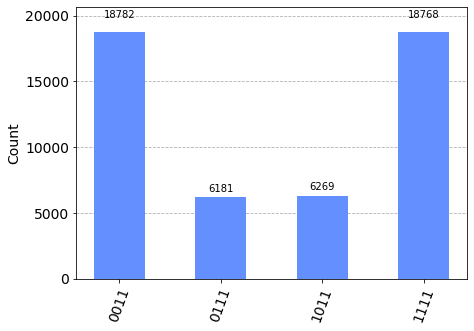

In [535]:
n_shots=50000
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit_1, backend=backend_total), shots=n_shots)
counts = job.result().get_counts()
plot_histogram(counts)

# Storing probabilities

In [536]:
for i in counts:
    counts[i]/=n_shots
counts

{'0111': 0.12362, '1011': 0.12538, '1111': 0.37536, '0011': 0.37564}

In [537]:
statevector=np.zeros(2**tot_qubit)
for i in counts:
    statevector[int(i,2)]=counts[i]
statevector

array([0.     , 0.     , 0.     , 0.37564, 0.     , 0.     , 0.     ,
       0.12362, 0.     , 0.     , 0.     , 0.12538, 0.     , 0.     ,
       0.     , 0.37536])

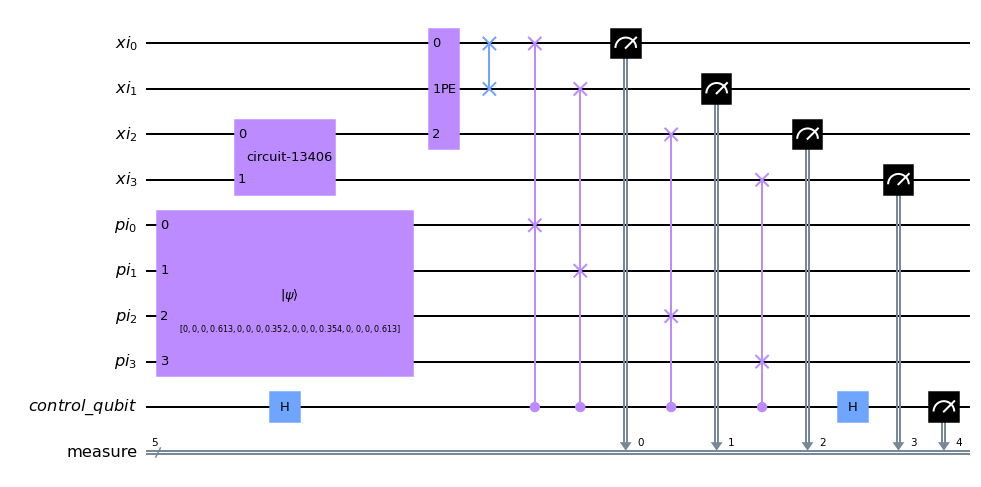

In [538]:

tot_qubit = resolution+len(example_matrix)

qr_total_xi = QuantumRegister(tot_qubit, 'xi')
qr_total_pi = QuantumRegister(tot_qubit, 'pi')
qr_control = QuantumRegister(1, 'control_qubit')
n_classical_register=tot_qubit+1
classical = ClassicalRegister(n_classical_register, 'measure')

total_circuit_2 = QuantumCircuit(qr_total_xi,qr_total_pi,qr_control ,classical, name='matrix')

total_circuit_2.append(matrix_circuit.to_gate(), qr_total_xi[2:tot_qubit])
total_circuit_2.append(pe.to_gate(), qr_total_xi[0:tot_qubit-1])

total_circuit_2.swap(qr_total_xi[0],qr_total_xi[1])
total_circuit_2.initialize(np.sqrt(statevector),qr_total_pi)
total_circuit_2.h(qr_control)
for i in range(tot_qubit):
    total_circuit_2.cswap(control_qubit=qr_control, target_qubit1=qr_total_xi[i],target_qubit2=qr_total_pi[i])

'''total_circuit.cswap(control_qubit=qr_control, target_qubit1=1,target_qubit2=5)
total_circuit.cswap(control_qubit=qr_control, target_qubit1=2,target_qubit2=6)
total_circuit.cswap(control_qubit=qr_control, target_qubit1=3,target_qubit2=7)'''

total_circuit_2.h(qr_control)
total_circuit_2.measure(qr_total_xi,classical[0:n_classical_register-1])
total_circuit_2.measure(qr_control,classical[n_classical_register-1])

total_circuit_2.draw("mpl")

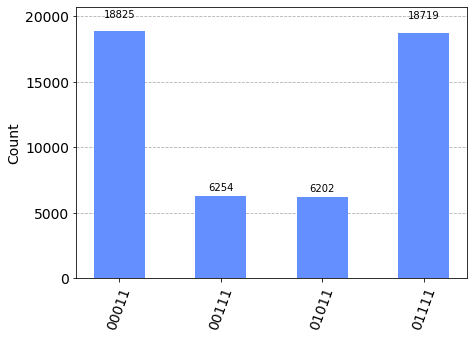

In [539]:
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit_2, backend=backend_total), shots=n_shots)
counts_for_sign = job.result().get_counts()
plot_histogram(counts_for_sign)

In [540]:
tmp=np.zeros(2**tot_qubit)

for c in counts_for_sign:
    if c[0]=='0':
        tmp[int(c[1:],2)]=counts_for_sign[c]
tmp

array([    0.,     0.,     0., 18825.,     0.,     0.,     0.,  6254.,
           0.,     0.,     0.,  6202.,     0.,     0.,     0., 18719.])

In [541]:
statevector

array([0.     , 0.     , 0.     , 0.37564, 0.     , 0.     , 0.     ,
       0.12362, 0.     , 0.     , 0.     , 0.12538, 0.     , 0.     ,
       0.     , 0.37536])

In [542]:
sign_dictionary={}
sign=0
for e, (count, prob) in enumerate(zip(tmp, statevector)):
    if count>0.4*prob*n_shots:
        sign=1
    else:
        sign=-1
    if prob==0:
        sign=0
    sign_dictionary.update({bin(e)[2:].zfill(tot_qubit):sign})

In [543]:
sign_dictionary

{'0000': 0,
 '0001': 0,
 '0010': 0,
 '0011': 1,
 '0100': 0,
 '0101': 0,
 '0110': 0,
 '0111': 1,
 '1000': 0,
 '1001': 0,
 '1010': 0,
 '1011': 1,
 '1100': 0,
 '1101': 0,
 '1110': 0,
 '1111': 1}

In [544]:
statevector_dictionary={}

for e,key in enumerate(sign_dictionary):
    statevector_dictionary[key]=sign_dictionary[key]*np.sqrt(statevector[e])

statevector_dictionary

{'0000': 0.0,
 '0001': 0.0,
 '0010': 0.0,
 '0011': 0.6128947707396434,
 '0100': 0.0,
 '0101': 0.0,
 '0110': 0.0,
 '0111': 0.35159635948058393,
 '1000': 0.0,
 '1001': 0.0,
 '1010': 0.0,
 '1011': 0.3540903839417275,
 '1100': 0.0,
 '1101': 0.0,
 '1110': 0.0,
 '1111': 0.6126663039534653}

# Da qui capire come calcolare i valori dell'autovettore


In [545]:
#remove eigenvector under threshold
statevector_dictionary_up_threshold={}
statevector_dictionary_down_threshold={}
for key in list(statevector_dictionary.keys()):
    if key[-2:]=='11':
        statevector_dictionary_up_threshold.update({key:statevector_dictionary[key]})
    elif key[-2:]=='11':
        statevector_dictionary_down_threshold.update({key:statevector_dictionary[key]})
#normalize using the mean 

statevector_dictionary_up_threshold,statevector_dictionary_down_threshold

({'0011': 0.6128947707396434,
  '0111': 0.35159635948058393,
  '1011': 0.3540903839417275,
  '1111': 0.6126663039534653},
 {})

In [548]:
norm_up=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_up_threshold.values()))**2))))
#norm_down=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_down_threshold.values()))**2))))
for k in statevector_dictionary_up_threshold:
    statevector_dictionary_up_threshold[k]*=norm_up
    
    
'''for k_d in statevector_dictionary_down_threshold:
    statevector_dictionary_down_threshold[k_d]*=norm_down
statevector_dictionary_up_threshold,statevector_dictionary_down_threshold'''

'for k_d in statevector_dictionary_down_threshold:\n    statevector_dictionary_down_threshold[k_d]*=norm_down\nstatevector_dictionary_up_threshold,statevector_dictionary_down_threshold'

$$\left|01\right\rangle(\frac{1}{2}|00\rangle-\frac{1}{2}|01\rangle-\frac{1}{2}|10\rangle+\frac{1}{2}|11\rangle) =$$

$$=\left|01\right\rangle\frac{1}{2}(|0\rangle(|0\rangle-|1\rangle)-|1\rangle(|0\rangle-|1\rangle)=$$

$$=\left|01\right\rangle\frac{1}{2}(-|0\rangle(-|0\rangle+|1\rangle)+|1\rangle(-|0\rangle+|1\rangle)=$$

$$=\left|01\right\rangle\frac{1}{2}((-|0\rangle+|1\rangle)\otimes(-|0\rangle+|1\rangle))=$$

$$=\left|01\right\rangle\left(\left(-\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right)\otimes\left(-\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right)\right)=$$


$$\left|00\right\rangle(0.0012|00\rangle+0.0013|01\rangle+0.0013|10\rangle+0.0048|11\rangle)+\left|01\right\rangle(0.0065|00\rangle+0.00126|01\rangle+0.00126|10\rangle+0.0405|11\rangle)+\left|10\right\rangle(0.1105|00\rangle+0.2897|01\rangle+0.2897|10\rangle+0.892|11\rangle)+\left|11\right\rangle(-0.0049|00\rangle-0.0108|01\rangle-0.0108|10\rangle-0.0341|11\rangle) =$$




In [432]:
statevector_up=list(statevector_dictionary_up_threshold.values())
#statevector_down=list(statevector_dictionary_down_threshold.values())

middle_idx=len(statevector_up)//2
statevector_up=statevector_up[middle_idx:]

result=[]
for idx in range(0, len(statevector_up), 2):
    result.append(np.sqrt(np.asarray(statevector_up[idx:idx+2]))*np.sign(statevector_up))

statevector_down=statevector_down[middle_idx:]

for idx in range(0, len(statevector_down), 2):
    result.append(np.sqrt(abs(np.asarray(statevector_down[idx:idx+2])))*np.sign(statevector_down))
   
result

[array([0.70908551, 0.70461201]), array([-0.70529052,  0.70926095])]